In [1]:
import torch
import torch.nn.functional as F

In [2]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-08-12 15:57:37--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-08-12 15:57:38 (5.96 MB/s) - ‘names.txt’ saved [228145/228145]



In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [5]:
class Linear:
  def __init__(self, fan_in,fan_out,bias=True):

    self.w = torch.randn((fan_in,fan_out))
    self.b = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x @ self.w
    if self.b is not None:
      self.out+= self.b
      return self.out
    else :
      return self.out

  def parameters(self):
    return [self.w] + ([] if self.b is None else [self.b])

class Batchnorm1d:
  def __init__(self,dim, momentum = 0.01, eps = 1e-5):
    self.momentum = momentum
    self.eps = eps
    self.training = True
    self.beta = torch.zeros(dim)
    self.gamma = torch.ones(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self,x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim,keepdim = True)
      xvar = x.var(dim,keepdim = True)
    else:
      xmean = self.running_mean
      xvar = self.running_var

    xhat = (x-xmean)/torch.sqrt(xvar+self.eps)
    self.out = self.gamma * xhat + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma,self.beta]

class tanh:
  def __call__(self,x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

class Embedding:
  def __init__(self,number_embed, embed_dim):
    self.embed = torch.randn((number_embed, embed_dim))

  def __call__(self,x):
    self.out = self.embed[x]
    return self.out

  def parameters(self):
    return [self.embed]

class Sequential:
  def __init__(self,layers):
    self.layers = layers

  def __call__(self,x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

class FlattenConsecutive:
  def __init__(self,n):
    self.n = n

  def __call__(self,x):
    B,T,C = x.shape
    x = x.view(-1,T//self.n,C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

In [6]:
n_embed = 24
n_hidden = 128
model = Sequential([
    Embedding(vocab_size,n_embed),
    FlattenConsecutive(2), Linear(2*n_embed, n_hidden, bias = False), Batchnorm1d(n_hidden ), tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden, bias = False), Batchnorm1d(n_hidden), tanh(),
    FlattenConsecutive(2), Linear(2*n_hidden, n_hidden, bias = False), Batchnorm1d(n_hidden), tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
  model.layers[-1].w*=0.1

print(sum([p.nelement() for p in model.parameters()]))

for p in model.parameters():
  p.requires_grad = True

76579


In [7]:
epochs = 200000
lossi = []

for i in range(epochs):
  ix = torch.randint(0,Xtr.shape[0],(32,))
  Xb, Yb = Xtr[ix],Ytr[ix]

  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  for p in model.parameters():
    p.grad = None
  loss.backward()

  lr = 0.1 if i<15000 else 0.01
  for p in model.parameters():
    p.data -= lr * p.grad

  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{epochs:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.4345
  10000/ 200000: 2.3519
  20000/ 200000: 2.0935
  30000/ 200000: 2.1442
  40000/ 200000: 2.5183
  50000/ 200000: 2.5269
  60000/ 200000: 2.2356
  70000/ 200000: 2.1313
  80000/ 200000: 2.2863
  90000/ 200000: 2.1007
 100000/ 200000: 2.1815
 110000/ 200000: 2.1590
 120000/ 200000: 2.2897
 130000/ 200000: 2.0734
 140000/ 200000: 2.2470
 150000/ 200000: 2.2557
 160000/ 200000: 2.1088
 170000/ 200000: 1.8585
 180000/ 200000: 1.8024
 190000/ 200000: 2.3284


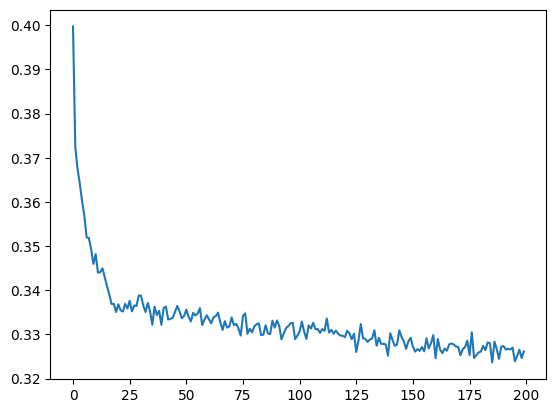

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [14]:
@torch.no_grad()
def split_loss(split):
  t = {
      'train' : (Xtr,Ytr),
      'dev' : (Xdev,Ydev),
      'test' : (Xte,Yte)
  }
  x,y = t[split]
  logits = model(x)
  loss = F.cross_entropy(logits,y)
  print(f'{split} loss : {loss.item()}')

split_loss('train')
split_loss('dev')

train loss : 2.0966198444366455
dev loss : 2.125225782394409


In [16]:
for layer in model.layers:
  layer.training = False

In [24]:
for i in range(20):
  context = [0] * block_size
  out = []
  while(True):
    logits = model(torch.tensor([context]))
    prob = F.softmax(logits,dim = 1)
    r = torch.multinomial(prob,num_samples = 1).item()
    context = context[1:]+[r]
    out.append(itos[r])
    if r == 0:
      break
  print(''.join(out))

ayve.
emillie.
stushya.
zebiah.
ariyah.
lacelli.
pianna.
kakear.
zamisa.
odien.
eyata.
joenstisreno.
evilyn.
tarvel.
kelra.
khlyn.
aklee.
fayya.
aasie.
gricantlay.
